In [4]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Scaling
from sklearn.preprocessing import MinMaxScaler

# Time series statistics
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Deep learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

In [7]:
# Load cleaned dataset (upload to Colab)
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train_clean.csv")

# Convert Date to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Sort by date (MANDATORY)
df = df.sort_values("Date")

# Aggregate total daily sales
daily_sales = df.groupby("Date")["Sales"].sum()

daily_sales.head()

/tmp/ipython-input-1922420546.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train_clean.csv")


,Sales
Date,
2013-01-01,97235
2013-01-02,6949829
2013-01-03,6347820
2013-01-04,6638954
2013-01-05,5951593


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Perform ADF test
adf_result = adfuller(daily_sales)

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -4.761614524595615
p-value: 6.436731330559343e-05


<Figure size 1000x400 with 0 Axes>

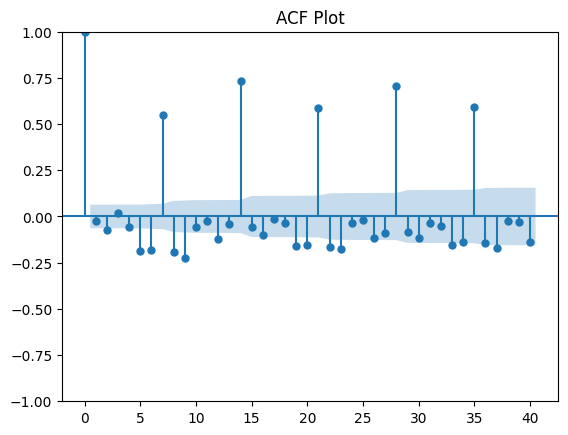

<Figure size 1000x400 with 0 Axes>

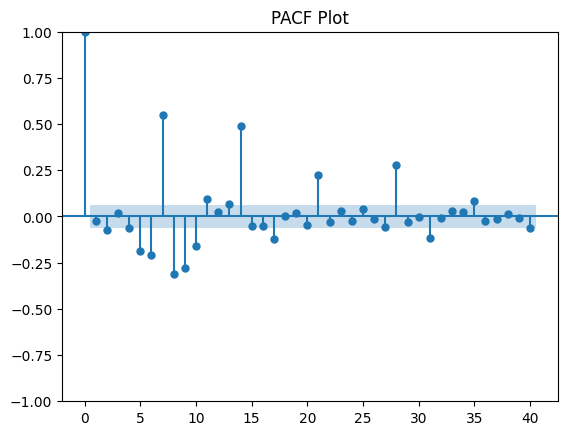

In [9]:
# Ploting ACF and PACF
plt.figure(figsize=(10,4))
plot_acf(daily_sales, lags=40)
plt.title("ACF Plot")
plt.show()

plt.figure(figsize=(10,4))
plot_pacf(daily_sales, lags=40)
plt.title("PACF Plot")
plt.show()

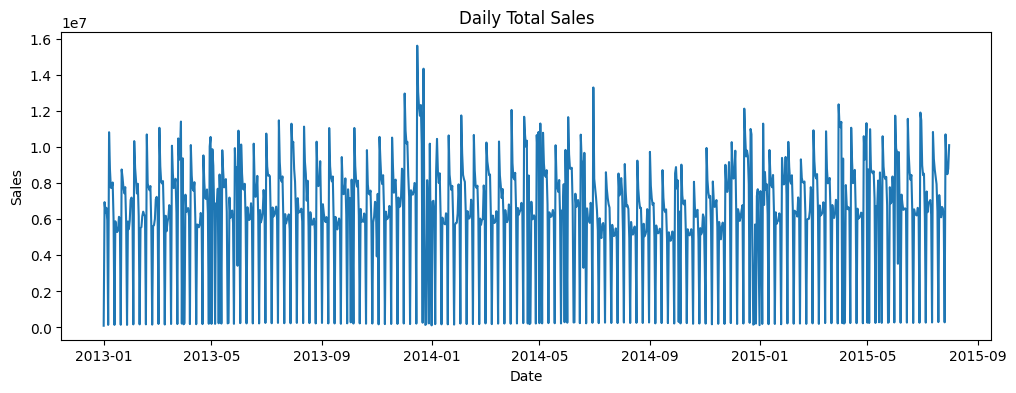

In [10]:
# Daily sales time series

plt.figure(figsize=(12,4))
plt.plot(daily_sales)
plt.title("Daily Total Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

In [28]:
# Convert to numpy array
store_1 = df[df["Store"] == 1].sort_values("Date")
sales_values = store_1["Sales"].values.reshape(-1,1)

In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
sales_scaled = scaler.fit_transform(sales_values)

In [30]:
# Creating Sliding Window
TIME_STEPS = 30  # number of past days

def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(sales_scaled, TIME_STEPS)

X.shape, y.shape

((751, 30), (751,))

In [31]:
# Define split index (80% train, 20% test)
split_index = int(0.8 * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [32]:
# Reshape to 3D format
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_train.shape, X_test.shape

((600, 30, 1), (151, 30, 1))

In [33]:
# Building LSTM Model

model = Sequential()

# LSTM layer
model.add(
    LSTM(
        units=50,
        return_sequences=False,
        input_shape=(X_train.shape[1], 1)
    )
)

# Dropout for regularization
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1))

# Compile model
model.compile(
    optimizer="adam",
    loss="mean_squared_error"
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Training LSTM MOdel

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Train model
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1139 - val_loss: 0.1408
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0619 - val_loss: 0.1280
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0573 - val_loss: 0.1291
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0608 - val_loss: 0.1262
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0570 - val_loss: 0.1238
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0606 - val_loss: 0.1220
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0541 - val_loss: 0.1228
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0621 - val_loss: 0.1185
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0529 - val_loss: 0.1178
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0530 - val_loss: 0.1159
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0540 - val_loss: 0.1107
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0

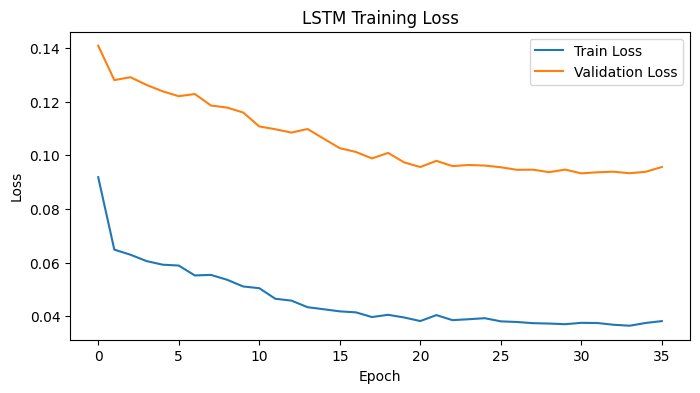

In [35]:
# Ploting Training & Validation Loss
plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("LSTM Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [36]:
# Predict on test data
y_pred = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [37]:
# Inverse scaling
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = scaler.inverse_transform(y_pred)

In [38]:
# Evaluate Model
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

mae, rmse

(465.83461655370445, 588.2964868718332)

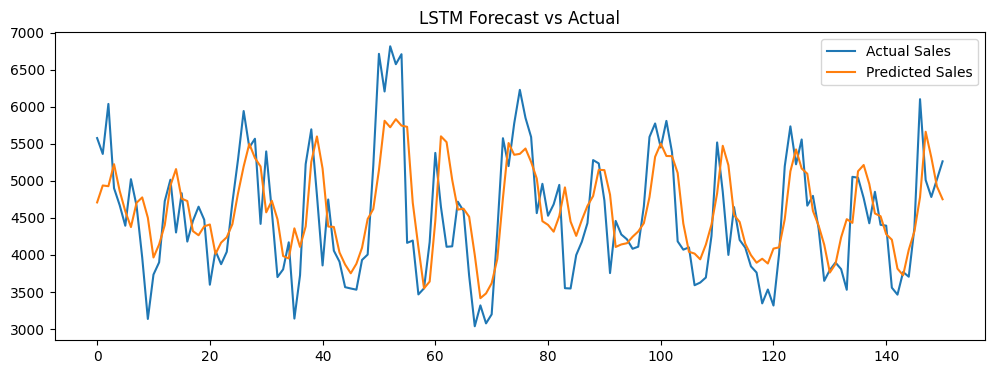

In [39]:
# Ploting Actual vs Predicated sale
plt.figure(figsize=(12,4))
plt.plot(y_test_inv, label="Actual Sales")
plt.plot(y_pred_inv, label="Predicted Sales")
plt.legend()
plt.title("LSTM Forecast vs Actual")
plt.show()

In [40]:
lstm_results = pd.DataFrame({
    "Model": ["LSTM"],
    "MAE": [mae],
    "RMSE": [rmse]
})

lstm_results.to_csv("lstm_results.csv", index=False)

print("LSTM results saved.")

LSTM results saved.


In [41]:
# Save test data for reproducibility
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)

print("Test data saved for reproducibility.")

Test data saved for reproducibility.


In [43]:
from sklearn.preprocessing import MinMaxScaler
import joblib

# Recreate scaler exactly as used in LSTM
scaler = MinMaxScaler(feature_range=(-1,1))

sales_scaled = scaler.fit_transform(sales_values)

# Save scaler
joblib.dump(scaler, "scaler.pkl")

print("Scaler recreated and saved successfully.")

Scaler recreated and saved successfully.


In [44]:
# Save LSTM model
model.save("lstm_model.h5")

print("LSTM model saved successfully.")

LSTM model saved successfully.
